# Machine Learning 2 Assignment 2

## Junyoung Jung 

In [81]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torch.optim import SGD
import torch.nn
import time
import numpy as np

### a) Load CIFAR10 dataset as follows:

In [82]:
trainset = datasets.CIFAR10(root='./CIFARdata', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./CIFARdata', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


### b) Visualize at least one image for each class. You may need to look into how dataset is implemented in PyTorch.

In [83]:
labels_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'}

In [84]:
def visualize_image(data):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    check_box = [0 for i in range(10)]
    img, label = 0, 0
    for i in range(1, cols * rows + 1):
        for j in range(len(trainset)):
            img, label = data[j]
            if check_box[label] == 1:
                continue
            else:
                check_box[label] = 1
                break
        figure.add_subplot(rows, cols, i)
        plt.title(labels_dict[label])
        plt.axis("off")
        img = img.permute(1, 2, 0)
        plt.imshow(img.squeeze(), cmap='gray')
    plt.show()

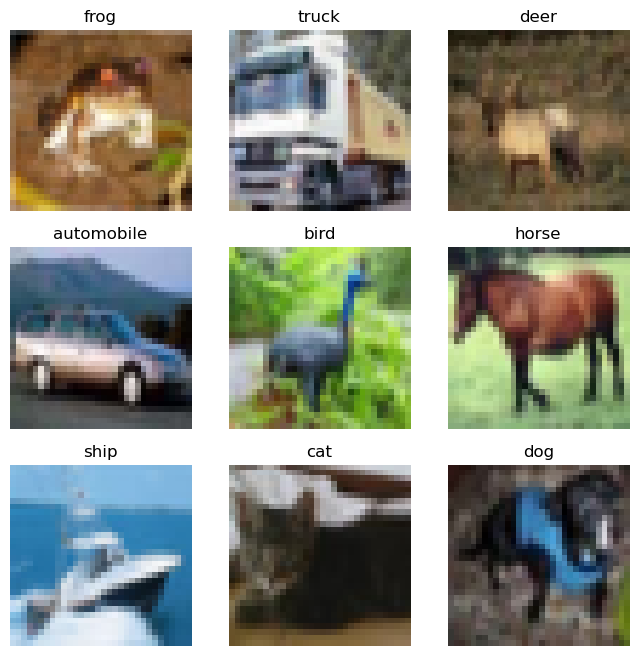

In [85]:
visualize_image(trainset)

### c) Split the trainset into training set and validation set with 90% : 10% ratio. Implement dataloaders for CIFAR10.

In [88]:
total_size = len(trainset)
train_size = int(0.9 * total_size)
val_size = int(0.1 * total_size)

batch_size = 64

train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# data shape[0] = (1, 3, 32, 32)
# label shape[0] = (1)

trainloader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_dataset, shuffle=True)
testloader = DataLoader(testset, shuffle=False)

anyclass1, anyclass2 = 4, 8
anyclass1_train_size, anyclass2_train_size = 0, 0

c_const = 0

### d) Choose any two classes. Then, make a SVM classifier (implement a loss function yourself. Do not use PyTorch implementations of loss functions.) and its training/validation/evaluation code to perform binary classification between those two classes.


### e) Train for 10 epochs with batch size 64.

In [89]:
class svm(torch.nn.Module):
    def __init__(self):
        super(svm, self).__init__()
        self.fc = torch.nn.Linear(32, 1)
        self.c = c_const

    def forward(self, x):
        fd = self.fc(x)
        return fd

    def hingeloss(self, data, label):
        w, c = self.fc.weight.squeeze(), self.c
        loss = torch.mean(torch.clamp(1 - data * label, min=0))
        loss += torch.sum(w * w) * 0.5 * c
        return loss

    def loss_fn(self, data, label):
        return torch.mean(torch.clamp(1 - data * label, min=0))

In [90]:
# small C maximizes margin, vice versa for bigger C
model = svm()
epoch = 10
batch_size = 64
learning_rate = 0.001
optimizer = SGD(model.parameters(), lr=learning_rate)

In [91]:
def train(model, optimizer, datas, batch_size):
    size = train_size
    model.train()

    for batch, (X, y) in enumerate(datas):
        label = 0
        for i in y:
            if i == anyclass1:
                label = 1
            elif i == anyclass2:
                label = -1
            else:
                continue

        optimizer.zero_grad()
        prediction = model(X)
        loss = model.hingeloss(prediction, label)
        loss.backward()
        optimizer.step()
        if batch % batch_size == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [92]:
def validation(model):
    size = 0
    model.eval()
    val_loss, correct = 0, 0
    num_batches = len(valloader)

    with torch.no_grad():
        print("WITH CUSTOM HINGELOSS")
        for X, y in valloader:
            if y == anyclass1:
                y = 1
                size += 1
            elif y == anyclass2:
                y = -1
                size += 1
            else:
                continue
            pred = model(X)
            val_loss += model.hingeloss(pred, y).item()
            if model.loss_fn(pred, y) < 1:
                correct += 1

    val_loss /= num_batches
    print(f"Total number: {size}, correct: {correct} ")
    correct /= size

    print(f"Validation Error: \n Accuracy: {(100 * correct)}%, Avg loss: {val_loss:>8f} \n")

In [93]:
def test(model):
    size = 0
    n = 1
    model.eval()
    val_loss, correct = 0, 0
    num_batches = len(testloader)

    with torch.no_grad():
        for X, y in testloader:
            if y == anyclass1:
                y = 1
                size += 1
            elif y == anyclass2:
                y = -1
                size += 1
            else:
                continue
            pred = model(X)
            val_loss += model.hingeloss(pred, y).item()
            if model.loss_fn(pred, y) < 1:
                correct += 1

    val_loss /= num_batches
    print(f"Total number: {size}, correct: {correct} ")
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct)}%, Avg loss: {val_loss:>8f} \n")

### Epoch = 10, Learning rate = 0.01, C = 1, batch size = 64

In [96]:
epoch = 10 
learning_rate = 0.01 
c_const = 1
batch_size = 64
model = svm()
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [97]:
print("Training without Normalization")
for epoch in range(epoch):
    start_time = time.time()
    print(f'Epoch {epoch + 1}')
    train(model, optimizer, trainloader, batch_size)
    print(f'Time took for step [{epoch}]: {(time.time() - start_time) / 60:>0.2f} mins')

Training without Normalization
Epoch 1
Training loss: 1.082309  [   64/45000]
Training loss: 1.087091  [ 4160/45000]
Training loss: 1.091987  [ 8256/45000]
Training loss: 1.088246  [12352/45000]
Training loss: 1.089527  [16448/45000]
Training loss: 1.260983  [20544/45000]
Training loss: 1.255458  [24640/45000]
Training loss: 1.076030  [28736/45000]
Training loss: 1.088399  [32832/45000]
Training loss: 1.078134  [36928/45000]
Training loss: 1.091607  [41024/45000]
Time took for step [0]: 0.09 mins
Epoch 2
Training loss: 1.259070  [   64/45000]
Training loss: 1.269424  [ 4160/45000]
Training loss: 1.081858  [ 8256/45000]
Training loss: 1.084958  [12352/45000]
Training loss: 1.100172  [16448/45000]
Training loss: 1.085282  [20544/45000]
Training loss: 1.084986  [24640/45000]
Training loss: 1.276553  [28736/45000]
Training loss: 1.082917  [32832/45000]
Training loss: 1.089467  [36928/45000]
Training loss: 1.268478  [41024/45000]
Time took for step [1]: 0.09 mins
Epoch 3
Training loss: 1.09

In [98]:
validation(model)

WITH CUSTOM HINGELOSS
Total number: 1013, correct: 568 
Validation Error: 
 Accuracy: 56.071076011846%, Avg loss: 0.232480 



In [99]:
test(model)

Total number: 2000, correct: 1088 
Test Error: 
 Accuracy: 54.400000000000006%, Avg loss: 0.229955 



### Epoch = 20, Learning rate = 0.005, C = 0.1, batch size = 64

In [101]:
epoch = 20
learning_rate = 0.005 
c_const = 0.1
batch_size = 64
model = svm()
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [102]:
print("Training without Normalization")
for epoch in range(epoch):
    start_time = time.time()
    print(f'Epoch {epoch + 1}')
    train(model, optimizer, trainloader, batch_size)
    print(f'Time took for step [{epoch}]: {(time.time() - start_time) / 60:>0.2f} mins')

Training without Normalization
Epoch 1
Training loss: 1.026908  [   64/45000]
Training loss: 1.042297  [ 4160/45000]
Training loss: 1.048595  [ 8256/45000]
Training loss: 1.012339  [12352/45000]
Training loss: 1.010004  [16448/45000]
Training loss: 1.011654  [20544/45000]
Training loss: 1.037791  [24640/45000]
Training loss: 0.997377  [28736/45000]
Training loss: 1.010591  [32832/45000]
Training loss: 1.001276  [36928/45000]
Training loss: 1.021540  [41024/45000]
Time took for step [0]: 0.09 mins
Epoch 2
Training loss: 1.016142  [   64/45000]
Training loss: 1.011531  [ 4160/45000]
Training loss: 1.012982  [ 8256/45000]
Training loss: 0.995867  [12352/45000]
Training loss: 1.052918  [16448/45000]
Training loss: 1.041051  [20544/45000]
Training loss: 0.998562  [24640/45000]
Training loss: 1.001849  [28736/45000]
Training loss: 1.002845  [32832/45000]
Training loss: 1.035445  [36928/45000]
Training loss: 1.046537  [41024/45000]
Time took for step [1]: 0.09 mins
Epoch 3
Training loss: 0.99

In [103]:
validation(model)

WITH CUSTOM HINGELOSS
Total number: 1013, correct: 419 
Validation Error: 
 Accuracy: 41.36229022704837%, Avg loss: 0.209050 



In [104]:
test(model)

Total number: 2000, correct: 817 
Test Error: 
 Accuracy: 40.849999999999994%, Avg loss: 0.206275 



### Epoch = 10, Learning rate = 0.01, C = 0.01, batch size = 128

In [106]:
epoch = 10
learning_rate = 0.01
c_const = 0.01
batch_size = 128
model = svm()
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [107]:
print("Training without Normalization")
for epoch in range(epoch):
    start_time = time.time()
    print(f'Epoch {epoch + 1}')
    train(model, optimizer, trainloader, batch_size)
    print(f'Time took for step [{epoch}]: {(time.time() - start_time) / 60:>0.2f} mins')

Training without Normalization
Epoch 1
Training loss: 0.892820  [  128/45000]
Training loss: 1.107249  [16512/45000]
Training loss: 0.912253  [32896/45000]
Time took for step [0]: 0.08 mins
Epoch 2
Training loss: 1.108277  [  128/45000]
Training loss: 0.904252  [16512/45000]
Training loss: 0.893358  [32896/45000]
Time took for step [1]: 0.08 mins
Epoch 3
Training loss: 0.907379  [  128/45000]
Training loss: 1.120181  [16512/45000]
Training loss: 1.096998  [32896/45000]
Time took for step [2]: 0.09 mins
Epoch 4
Training loss: 1.111344  [  128/45000]
Training loss: 0.914359  [16512/45000]
Training loss: 1.094918  [32896/45000]
Time took for step [3]: 0.09 mins
Epoch 5
Training loss: 0.901774  [  128/45000]
Training loss: 1.098533  [16512/45000]
Training loss: 0.904122  [32896/45000]
Time took for step [4]: 0.09 mins
Epoch 6
Training loss: 0.897439  [  128/45000]
Training loss: 0.903251  [16512/45000]
Training loss: 0.899587  [32896/45000]
Time took for step [5]: 0.09 mins
Epoch 7
Trainin

In [108]:
validation(model)

WITH CUSTOM HINGELOSS
Total number: 1013, correct: 544 
Validation Error: 
 Accuracy: 53.701875616979265%, Avg loss: 0.198493 



In [109]:
test(model)

Total number: 2000, correct: 1055 
Test Error: 
 Accuracy: 52.75%, Avg loss: 0.195728 



### f) Perform data normalization. You may need to look into how to use datasets in PyTorch.

In [110]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = datasets.CIFAR10(root='./CIFARdata', train=True, download=True, transform=train_transform)
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

trainloader2 = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, shuffle=True)

Files already downloaded and verified


### g) Again, train for 10 epochs with batch size 64 after data normalization. Write down your observations.

### Epoch = 10, Learning rate = 0.01, C = 1, batch size = 64

In [111]:
epoch = 10
learning_rate = 0.01
c_const = 1
batch_size = 64
model = svm()
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [112]:
print("Normalized data training")
for epoch in range(epoch):
    start_time = time.time()
    print(f'Epoch {epoch + 1}')
    train(model, optimizer, trainloader2, batch_size)
    print(f'Time took for step [{epoch}]: {(time.time() - start_time) / 60:>0.2f} mins')

Normalized data training
Epoch 1
Training loss: 1.309370  [   64/45000]
Training loss: 1.082155  [ 4160/45000]
Training loss: 1.317815  [ 8256/45000]
Training loss: 1.095754  [12352/45000]
Training loss: 1.309292  [16448/45000]
Training loss: 1.065737  [20544/45000]
Training loss: 1.092429  [24640/45000]
Training loss: 1.082456  [28736/45000]
Training loss: 1.311749  [32832/45000]
Training loss: 1.331719  [36928/45000]
Training loss: 1.323478  [41024/45000]
Time took for step [0]: 0.13 mins
Epoch 2
Training loss: 1.307916  [   64/45000]
Training loss: 1.062793  [ 4160/45000]
Training loss: 1.318889  [ 8256/45000]
Training loss: 1.318845  [12352/45000]
Training loss: 1.076771  [16448/45000]
Training loss: 1.092171  [20544/45000]
Training loss: 1.311854  [24640/45000]
Training loss: 1.069979  [28736/45000]
Training loss: 1.322081  [32832/45000]
Training loss: 1.300770  [36928/45000]
Training loss: 1.096494  [41024/45000]
Time took for step [1]: 0.16 mins
Epoch 3
Training loss: 1.060885  

In [113]:
# Validation for normalized data
validation(model)

WITH CUSTOM HINGELOSS
Total number: 982, correct: 517 
Validation Error: 
 Accuracy: 52.64765784114053%, Avg loss: 0.231233 



In [114]:
# Testing for noramlized data
test(model)

Total number: 2000, correct: 1000 
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.237945 



### Epoch = 20, Learning rate = 0.005, C = 0.1, batch size = 64

In [115]:
epoch = 20
learning_rate = 0.005
c_const = 0.1
batch_size = 64
model = svm()
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [116]:
print("Normalized data training")
for epoch in range(epoch):
    start_time = time.time()
    print(f'Epoch {epoch + 1}')
    train(model, optimizer, trainloader2, batch_size)
    print(f'Time took for step [{epoch}]: {(time.time() - start_time) / 60:>0.2f} mins')

Normalized data training
Epoch 1
Training loss: 1.077647  [   64/45000]
Training loss: 1.087910  [ 4160/45000]
Training loss: 1.064675  [ 8256/45000]
Training loss: 0.856594  [12352/45000]
Training loss: 1.111474  [16448/45000]
Training loss: 1.104451  [20544/45000]
Training loss: 1.003325  [24640/45000]
Training loss: 0.961878  [28736/45000]
Training loss: 1.094287  [32832/45000]
Training loss: 1.062907  [36928/45000]
Training loss: 1.100893  [41024/45000]
Time took for step [0]: 0.14 mins
Epoch 2
Training loss: 0.977136  [   64/45000]
Training loss: 0.976918  [ 4160/45000]
Training loss: 1.060336  [ 8256/45000]
Training loss: 1.145822  [12352/45000]
Training loss: 1.122303  [16448/45000]
Training loss: 0.934479  [20544/45000]
Training loss: 1.193952  [24640/45000]
Training loss: 0.798933  [28736/45000]
Training loss: 1.118501  [32832/45000]
Training loss: 0.901290  [36928/45000]
Training loss: 1.122984  [41024/45000]
Time took for step [1]: 0.13 mins
Epoch 3
Training loss: 1.140810  

In [117]:
# Validation for normalized data
validation(model)

WITH CUSTOM HINGELOSS
Total number: 982, correct: 624 
Validation Error: 
 Accuracy: 63.543788187372705%, Avg loss: 0.180941 



In [118]:
# Testing for normalized data
test(model)

Total number: 2000, correct: 1000 
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.196371 



### Epoch = 10, Learning rate = 0.01, C = 0.01, batch size = 128

In [120]:
epoch = 10
learning_rate = 0.01
c_const = 0.01
batch_size = 128
model = svm()
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [121]:
print("Normalized data training")
for epoch in range(epoch):
    start_time = time.time()
    print(f'Epoch {epoch + 1}')
    train(model, optimizer, trainloader2, batch_size)
    print(f'Time took for step [{epoch}]: {(time.time() - start_time) / 60:>0.2f} mins')

Normalized data training
Epoch 1
Training loss: 1.013185  [   64/45000]
Training loss: 1.050813  [ 8256/45000]
Training loss: 1.066830  [16448/45000]
Training loss: 1.061795  [24640/45000]
Training loss: 1.062763  [32832/45000]
Training loss: 0.983584  [41024/45000]
Time took for step [0]: 0.14 mins
Epoch 2
Training loss: 1.078254  [   64/45000]
Training loss: 1.045282  [ 8256/45000]
Training loss: 1.055562  [16448/45000]
Training loss: 0.984731  [24640/45000]
Training loss: 0.995019  [32832/45000]
Training loss: 1.029828  [41024/45000]
Time took for step [1]: 0.13 mins
Epoch 3
Training loss: 0.971430  [   64/45000]
Training loss: 1.084576  [ 8256/45000]
Training loss: 1.017191  [16448/45000]
Training loss: 0.965347  [24640/45000]
Training loss: 0.982833  [32832/45000]
Training loss: 0.976659  [41024/45000]
Time took for step [2]: 0.13 mins
Epoch 4
Training loss: 0.999734  [   64/45000]
Training loss: 0.967230  [ 8256/45000]
Training loss: 1.026137  [16448/45000]
Training loss: 0.98855

In [122]:
# Validation for normalized data
validation(model)

WITH CUSTOM HINGELOSS
Total number: 982, correct: 356 
Validation Error: 
 Accuracy: 36.252545824847246%, Avg loss: 0.213724 



In [123]:
# Testing for normalized data
test(model)

Total number: 2000, correct: 1000 
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.204804 

